# **Lab 7a - Explainable and Trustworthy AI**


---



**Teacher**: Eliana Pastor (eliana.pastor@polito.it)


---

## **Evaluating explanations - Tabular data**

We evaluate the explanation of individual predictions provided by SHAP.
We focus on the [Adult dataset](https://archive.ics.uci.edu/dataset/2/adult) and a Random Forest classifier, as done for Lab 3b.


> **Dataset.** The Adult dataset, also known as the "Census Income" dataset, contains demographic information about people, such as age, education, occupation, marital status and more, extracted from the 1994 U.S. Census Bureau database. **Each entry** in the dataset represents a **person**, and the associated **task** is to **predict whether an individual earns more than $50,000 per year** or less.

> **Model**

1. We first load the Adult dataset.
  * We use the dataset available in the SHAP [library](https://shap.readthedocs.io/en/latest/generated/shap.datasets.adult.html).
  * SHAP provides two versions of Adult dataset: an already preprocessed, that we will use for both the classifier and the explainer; the original dataset version, to interpret the results.
2. We split the Adult dataset. 80/20 train-test ratio.
3. We then rain a RandomForestClassifier and fit it over the training dataset. Evaluate the model.


> **Explanations**

4. Use the `shap.Explainer` to explain the instance `id=0` .
5. **Plot** with a bar chart from `matplotlib.pyplot` the **Shapley values** for the instance `id=0` .

In the following, we load the dataset, train the model and generate explanations with SHAP, as done for Lab 3b

In [1]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 4.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

import random
random.seed(42)

#### Data loading and splitting

We use the dataset already processed available in the shap library (see Lab 3b)

In [3]:
# Load the data with display=False. This dataset has been processed (label encoding)
X, y = shap.datasets.adult(display=False)
display(X.head(3))

# Load the data with display=True. This dataset still contains the categorical values.
X_display, y_display = shap.datasets.adult(display=True)
display(X_display.head(3))

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States


In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_display_test, y_display_test = X_display.loc[X_test.index], y_display[X_test.index]

#### Model training

In [14]:
# Train a RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train.values, y_train)     # che differenza c'è tra passare values e solo x_train??

RandomForestClassifier(random_state=42)

In [6]:
# Evaluate the model
accuracy = rf_clf.score(X_test.values, y_test)
accuracy

0.8556732688469215

#### SHAP - Explanation

In [7]:
# Consider an instance
id_instance = 0

instance_i, label_i = X_test.iloc[[id_instance]], y_test[0]
instance_i_display = X_display_test.iloc[[id_instance]]

predicted_class_i = rf_clf.predict(instance_i.values)[0]
display(instance_i)
print(f'True label: {label_i}')
print(f'Predicted label: {predicted_class_i}')

# Index of the predicted class
predicted_index = np.argmax(rf_clf.predict_proba(instance_i.values)[0])

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
26048,30.0,4,10.0,4,8,3,4,0,0.0,0.0,40.0,39


True label: False
Predicted label: False


In [8]:
# Compute the masker
masker = shap.maskers.Independent(data = X_train.values)

# Instanciate the shap.Explainer
explainer = shap.Explainer(rf_clf.predict_proba, masker=masker)

# Calculate the explainer over the sample_data
shap_values_explanation = explainer(instance_i)

# Estimated shapley values for the predicted class
shap_values_i = shap_values_explanation.values[:, :, predicted_index][0]

PermutationExplainer explainer: 2it [00:10, 10.48s/it]               


Text(0.5, 1.0, 'Shapley values for instance 0 \n w.r.t 0. Predicted class: False')

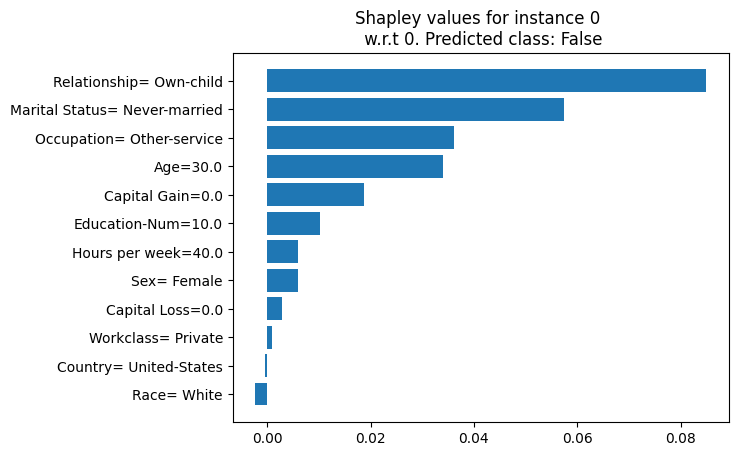

In [9]:
# Plot the shapley values

sorted_indices = np.argsort(shap_values_i)
feature_names_values = np.array([f'{f}={value}' for f, value in zip(instance_i_display.columns, instance_i_display.values[0])])

# Plot SHAP values
plt.barh(feature_names_values[sorted_indices], shap_values_i[sorted_indices])

# Plot title
plt.title(f'Shapley values for instance {id_instance} \n w.r.t {predicted_index}. Predicted class: {predicted_class_i}')


# **Exercises:**

## Single deletion

---


Single Deletion

>> Evaluates the change in output when removing/perturbing one feature

* Omitting the feature with the highest importance score for the explanation
should lead the highest change in the output of $f$
* Omitting the one with least importance should have no impact
* Omitting a feature that as no effect on the output should have importance 0

**Exercixe A - Study the impact of removing the most important feature**

1. Identify the most important feature for the prediction
Given the SHAP feature attribution score for the prediction of the instance $0$, identify the most important one (highest score)

2. Apply the single deletion of the most important feature

* Remove the most important feature
* Compute the prediction change of the perturbed instance with the original prediction probability
* Analyze the drop in the prediction change

#### 1. Which is the most important feature?

In [79]:
# Identify the most important feature --> Relationship

# Print the most important feature: attribute, attribute value (encoded and decoded)
most_important_feature_idx = sorted_indices[-1]
most_important_feature_name = instance_i.columns[most_important_feature_idx]
print(instance_i[most_important_feature_name])
print(instance_i_display[most_important_feature_name])

26048    3
Name: Relationship, dtype: int64
26048     Own-child
Name: Relationship, dtype: category
Categories (6, object): [' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
                         ' Unmarried', ' Wife']


#### 2. Remove just the most important feature.

Compute the change in the prediction when we remove the most important feature

>> How to mimic the removal. Examples:


** Option (i)  we can remove it by replacing the value of the most important attribute with a random one.

** Option (ii) we replace the value of the most important feature iteratively with all the other possible values, we measure how the prediction changes and compute the average change in the prediction.

** Option (ii) we replace the values of the most importan feature $M$ times with the attribute value of randomly sampled instances.

In [80]:
values = X_train[most_important_feature_name].unique()
prob_original = rf_clf.predict_proba(instance_i.values)[0][predicted_index]
sum = 0

for value in values:
  perturbed_instance = instance_i.values[0]
  perturbed_instance[most_important_feature_idx] = value
  prob_new = rf_clf.predict_proba(perturbed_instance.reshape(1, -1))[0][predicted_index]
  sum += (prob_original - prob_new)

  # print(perturbed_instance, sum)
print(f"Mean prediction changes is {sum/len(values)}")


Mean prediction changes is 0.030995240870240897


In [81]:
# Adopt one of the options above to identify the most important feature
n_possible_values = len(X_train[most_important_feature_name].unique())
replaced_instance = instance_i.copy()
prev_pred = predicted_class_i
cnt = 0

for i in range(n_possible_values):
  replaced_instance[most_important_feature_name] = i

  # Print the prediction change when removing the most important feature
  predicted_class_replaced = rf_clf.predict(replaced_instance.values)[0]
  if predicted_class_replaced != predicted_class_i:
    cnt += 1
  # display(replaced_instance)
  # print(f'True label: {label_i}')
  # print(f'Predicted label: {predicted_class_replaced}')

print(f"Prediction has changed {cnt} times")

Prediction has changed 0 times


Does this alone explain the prediction?

## Iterative deletion of the most important feature

---


>> Evaluates the change in output when iteratively removing/perturbing features

* We can omit in descending order (from the most important to the least) or ascending order
* Often we removed subsets, e.g., top-k most influential and least
* The impact is then summarized, e.g., Area over the Perturbation Curve, average difference in prediction scores by f

**Exercixe B - Study the impact of removing the top-K important feature**

1. Identify the top-K most important feature for the prediction
Given the SHAP feature attribution score for the prediction of the instance $0$, identify the top K important ones (highest scores)

2. Apply the iterative deletion of the K important features

* Remove iteratively the K most important features, from the most important to the top-K and compute the prediction change
* Compute the average prediction change

Note that we are measuring if the top-K feature are comprehensive. If they are comprehensive, they capture most of the information and hence we expect a high drop in prediction probability. We define this measure as **comprehensiveness**

3. Apply the iterative deletion for random features

* Reapply the process but for random K features. We investigate whether the drop is change is indeed larger for the features highlighted by SHAP

4. Compare the score for the delition of the top-K features for SHAP and random removal




#### 1. Which are the K=5 most important features?

In [87]:
# Identify the K most important features


#BOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

most_important_feature_idxs = sorted_indices[-5:-1]
most_important_feature_names = instance_i.columns[most_important_feature_idxs]
most_important_feature_idxs
# Print the K most important features (attribute, attribute value)

array([8, 0, 4, 3])

#### 2. Compute the iterative removal of the top-K most important features

In this case, we mimic the removal of a set of feature by replacing the values of the most important features $M$ times with the attribute value of randomly sampled instances.

We set $M$ = 50

In [ ]:
# Iterate over the K most important features
# Identify a set of k features that are the most important
### Mimic the removal by replacing the feature with a random instance.
### Repeat this process n_random_iterations times (e.g, 50) and accumulate the difference in prediction
# Repeat the process for k=1 to K=5 most important features (i.e., at the second iteration, remove the top 2 features, and so on)


#### 3. Repeat the process but using a random explanation

Compute the iterative removal for K random features

In [ ]:
# Repeat the iterative process above but for random features



#### 4. Compare the deletion of the most important feature with the random deletion of features

In [ ]:
# Print the prediction change when iteratively removing the top-k important feature and when removing random features

## Correlation with Leave-One-Out

**Exercixe C - Analyze the correlation with Leave-One-Out**


Compute the Leave-One-Out (LOO) importance and compare it with the SHAP values using the rank correlation.

LOO importance is a basic explainer computed by removing one feature at a time and computing the difference in prediction.

A measure of faithfulness is the correlation with LOO explanations.

####  1. Compute the Leave-One-Out (LOO) importance

The LOO importance is computed by removing one feature at a time and computing the difference in prediction.

In [ ]:
# Mimic the removal of one feature at a time and calculate the prediction change
# The prediction change is the difference between the prediction of the original instance and the prediction of the instance with the feature removed
# The prediction change is the LOO explanation, representing the importance of the feature


# leave_one_out_importance = ..

#### 2. Plot the leave-one-out importance

In [ ]:
# Use a bar plot to display the leave-one-out importance of the features

#### 3. Visually compare the importance from the SHAP scores with the leave-one-out importance

Plot the two explanations provided by SHAP and LOO

In [ ]:
# Compare the SHAP scores and leave-one-out importance scores: lot the SHAP scores and leave-one-out importance scores side by side


#### 4. Compute the rank correlation between the SHAP values and the leave-one-out importance

Compare the two explanation by computing a rank similarity score. For eaxample, use the spearmanr

In [ ]:
# Use a similar approach to compare SHAP scores and the leave-one-out importances. For example, use the Spearman correlation coefficient to compare the two sets of scores.


from scipy import stats
#res = stats.spearmanr(shap_scores, leave_one_out_importance)


## Iterative deletion of the least important feature


---


>> Evaluates the change in output when iteratively removing/perturbing features the least important. We expect a null or small average change i the prediction probability

**Exercixe D - Study the impact of removing the least-K important feature**

1. Identify the least-K most important feature for the prediction
Given the SHAP feature attribution score for the prediction of the instance $0$, identify the least K important ones (lowest score)

2. Apply the iterative deletion of the K important features

* Remove iteratively the K most important features, from the most important to the top-K and compute the prediction change
* Compute the average prediction change

Note that we are measuring if the top-K feature are sufficient. If they are suffient, they capture **alone** most of the information and hence we expect a null or small drop in prediction probability. We define this measure as **sufficiency**

3. Apply the iterative deletion for random features

* Reapply the process but for random K features.

4. Compare the score for the delition of the least-K features for SHAP and random removal


#### 1. Which are the K=5 least important features?

In [ ]:
# Identify the K=5 least important features


#### 2. Compute the iterative removal of the K least important features

In [ ]:
# Compute the iterative removal of the top-K least important features, as done for the most important features



#### 3. Repeat the process but using a random explanation

In [ ]:
# Compute the iterative removal for random features


#### 4. Compare the deletion of the most important feature with the random deletion of features

In [ ]:
# Print the iterative removal of the top-K least important features and random features
